In [109]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy 
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

from qiskit import QuantumCircuit
#from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

torch.backends.cudnn.benchmark = True

**Introduce experience replay.**

In [110]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cpu'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

**Networks definition.**

In [111]:
num_qubits = 4

def create_qnn():
    n_qubits = int(num_qubits/2)

    qc = QuantumCircuit(n_qubits)
    feature_map = ZFeatureMap(n_qubits)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn

def create_entanglement():
    qc = QuantumCircuit(num_qubits)
    feature_map =ZZFeatureMap(num_qubits)
    ansatz = EfficientSU2(num_qubits= num_qubits, reps = 1)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace = True)

    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn




qnn = create_qnn()
entanglement = create_entanglement()
print("QNN Training Parameters: ", qnn.num_weights)
print("QNN-Entangled Training Parameters: ", entanglement.num_weights)

QNN Training Parameters:  4
QNN-Entangled Training Parameters:  16


/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_7350/1593640690.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(
/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_7350/1593640690.py:31: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


In [112]:
class conv_nn(nn.Module):
    
    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv_start= nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        self.conv_finish= nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )


        size_out_conv = self.get_conv_size(rows, cols)

        self.linear_start = nn.Sequential(nn.Linear(size_out_conv, 2),
                                    TorchConnector(qnn),
                                    nn.Linear(4, n_act),
                                   )

        self.linear_finish = nn.Sequential(nn.Linear(size_out_conv, 2),
                                    TorchConnector(qnn),
                                    nn.Linear(4, n_act),
                                   )
        
        self.linear_entangle = nn.Sequential(nn.LazyLinear(4),
                                             TorchConnector(entanglement),
                                             nn.LazyLinear(n_act)
                                             )
        
    def forward(self, x1, x2):

        x1 = x1.view(len(x1), self.in_channels, self.rows, self.cols)
        out_conv_start = self.conv_start(x1).view(len(x1),-1)
        out_lin_start = self.linear_start(out_conv_start)

        x2 = x2.view(len(x2), self.in_channels, self.rows, self.cols)
        out_conv_finish = self.conv_finish(x2).view(len(x2),-1)
        out_lin_finish = self.linear_finish(out_conv_finish)
        out_lin = torch.cat((out_lin_start, out_lin_finish))
        out_lin = self.linear_entangle(out_lin)
        
        return out_lin
    
    def get_conv_size(self, x, y):
        out_conv = self.conv_start(torch.zeros(1,self.in_channels, x, y))
        return int(np.prod(out_conv.size()))
    

    

In [113]:
def get_qvalues(net, state_start, state_finish):
    state_start = torch.Tensor(state_start).to("cpu")
    state_finish = torch.Tensor(state_finish).to("cpu")
    qvalues = net(state_start, state_finish)
    qvalues_start, qvalues_finish = torch.chunk(qvalues, 2)
    
    return qvalues_start, qvalues_finish


In [114]:
def Qloss(batch_start, batch_finish, net, gamma=0.99, device="cpu"):
    #(states, actions, next_states, rewards, _ ), ()= batch

    states_start, actions_start, next_states_start, rewards_start, _ = batch_start

    states_finish, actions_finish, next_states_finish, rewards_finish, _ = batch_finish   
    # Move data for both agents to the desired device
    
    states_start = states_start.to(device)
    actions_start = actions_start.to(device)
    next_states_start = next_states_start.to(device)
    rewards_start = rewards_start.to(device)
    

    states_finish = states_finish.to(device)
    actions_finish = actions_finish.to(device)
    next_states_finish = next_states_finish.to(device)
    rewards_finish = rewards_finish.to(device)
    
    # Convert states and next_states to NumPy arrays
    states_start = states_start.cpu().detach().numpy()
    next_states_start = next_states_start.cpu().detach().numpy()

    states_finish = states_finish.cpu().detach().numpy()
    next_states_finish = next_states_finish.cpu().detach().numpy()

    # Create PyTorch tensors from the NumPy arrays
    states_tensor_start = torch.from_numpy(states_start).to(device)
    next_states_tensor_start = torch.from_numpy(next_states_start).to(device)

    states_tensor_finish = torch.from_numpy(states_finish).to(device)
    next_states_tensor_finish = torch.from_numpy(next_states_finish).to(device)


    # Perform the rest of the computation on the device
    lbatch_start = len(states_tensor_start)
    lbatch_finish = len(states_tensor_finish)

   
    #####################################

    state_action_values_start, state_action_values_finish  = get_qvalues(net,states_tensor_start.view(lbatch_start,-1), states_tensor_finish.view(lbatch_finish,-1))
    #state_action_values_start = state_action_values_start.transpose(0,1)
    
    #state_action_values_start = state_action_values_start.view(lbatch_start, 1)
    #state_action_values_start = state_action_values_start.view(-1, 1)
    
    state_action_values_start = state_action_values_start.gather(1, actions_start.unsqueeze(-1))
    state_action_values_start = state_action_values_start.squeeze(-1)

    state_action_values_finish = state_action_values_finish.gather(1, actions_finish.unsqueeze(-1))
    state_action_values_finish = state_action_values_finish.squeeze(-1)

    state_action_values_combined = torch.cat((state_action_values_start, state_action_values_finish))

    #####################################

    next_state_values_start, next_state_values_finish  = get_qvalues(net,next_states_tensor_start.view(lbatch_start, -1), next_states_tensor_finish.view(lbatch_finish, -1))


    next_state_values_start = next_state_values_start.max(1)[0]
    next_state_values_start = next_state_values_start.detach()
   
    expected_state_action_values_start = next_state_values_start * gamma + rewards_start


    next_state_values_finish = next_state_values_finish.max(1)[0]
    next_state_values_finish = next_state_values_finish.detach()

    
    expected_state_action_values_finish = next_state_values_finish * gamma + rewards_finish

    expected_state_action_values_combined = torch.cat((expected_state_action_values_start, expected_state_action_values_finish))
    
    '''
    # Move tensors to the desired device
    states = states.to(device)
    actions = actions.to(device)
    next_states = next_states.to(device)
    rewards = rewards.to(device)

    # Convert states and next_states to NumPy arrays
    states = states.cpu().detach().numpy()
    next_states = next_states.cpu().detach().numpy()

    # Create PyTorch tensors from the NumPy arrays
    states_tensor = torch.from_numpy(states).to(device)
    next_states_tensor = torch.from_numpy(next_states).to(device)

    # Perform the rest of the computation on the device
    lbatch = len(states_tensor)

    
    state_action_values = net(states_tensor.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    #state_action_values = torch.tensor(input_list).squeeze()
    
    next_state_values = net(next_states_tensor.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * gamma + rewards
    '''

    return nn.MSELoss()(state_action_values_combined, expected_state_action_values_combined)

**Import the maze and define the environment.**

In [115]:
from environment import MazeEnvironment

maze = np.load('./maze_generator/maze_10x10.npy')

start_position = [0,0]
end_position = [len(maze)-1, len(maze)-1]

maze_env = MazeEnvironment(maze, start_position, end_position)

In [116]:
maze_finish = np.load('./maze_generator/maze_10x10.npy')
maze_env_finish = MazeEnvironment(maze_finish, end_position, start_position)

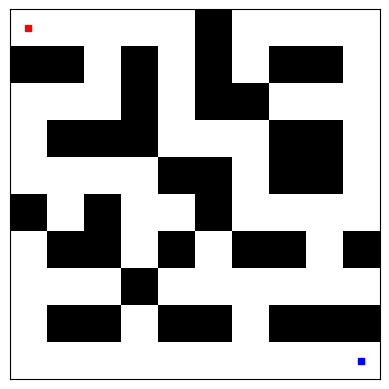

In [117]:
maze_env.draw('./results/maze_10.pdf')

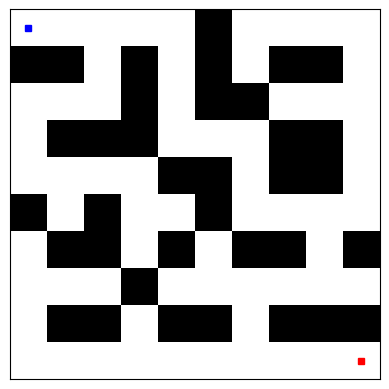

In [118]:
maze_env_finish.draw('./results/maze_10_finish.pdf')


**Define the agent and the buffer for experience replay.**

In [119]:
buffer_capacity = 10000
buffer_start_size = 1000

memory_buffer_start = ExperienceReplay(buffer_capacity)
memory_buffer_finish = ExperienceReplay(buffer_capacity)

In [120]:
from agent import Agent


agent_start = Agent(maze = maze_env,
              memory_buffer = memory_buffer_start,
              agent_id='Start',
              use_softmax = True
             )

agent_finish = Agent(maze = maze_env_finish, 
               memory_buffer = memory_buffer_finish,
               use_softmax = True,
               agent_id='Finish'
              )


** Define the network.**

In [121]:
net = conv_nn(len(maze), len(maze), 4).to('cpu')
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [122]:
device = torch.device("cpu")
batch_size = 24
gamma = 0.9

net.to(device)
#print("Number of Trainable Parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))

conv_nn(
  (conv_start): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_finish): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (linear_start): Sequential(
    (0): Linear(in_features=1152, out_features=2, bias=True)
    (1): TorchConnector()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (linear_finish): Sequential(
    (0): Linear(in_features=1152, out_features=2, bias=True)
    (1): TorchConnector()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (linear_entangle): Sequential(
    (0): LazyLinear(in_features=0, out_features=4, bias=True)
    (1): TorchConnector()
    (2): LazyLinear(in_features=0, out_features=4, bias=True)
  )
)

**Define the epsilon profile and plot the resetting probability.**

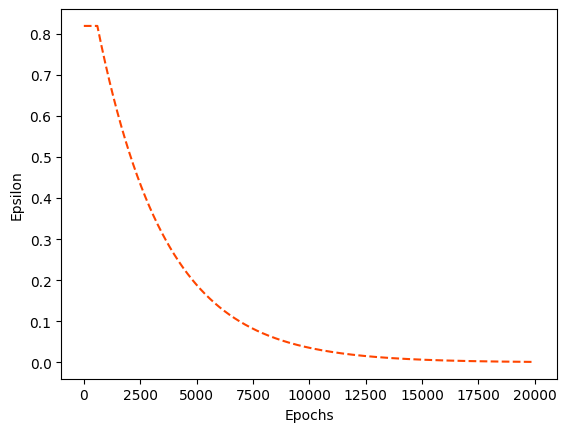

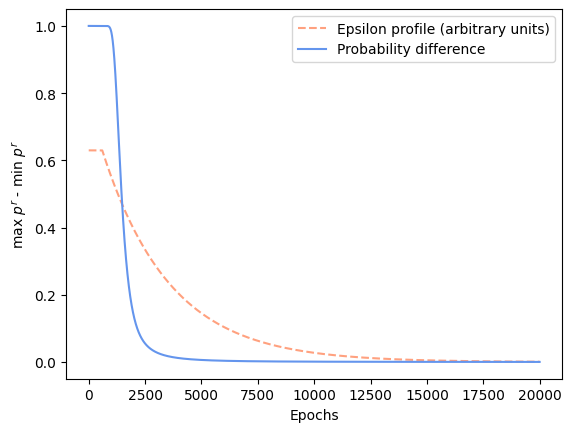

In [123]:
num_epochs = 20000

cutoff = 3000
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent_start.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

**Training the network.**

In [ ]:
loss_log = []
best_loss = 1e5

running_loss = 0

win_count = 0

for epoch in range(num_epochs):
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    agent_start.isgameon = True
    start_pos = agent_start.env.reset(eps)

    agent_finish.isgameon = True
    finish_pos = agent_finish.env.reset(eps)

   
    while agent_start.isgameon and agent_finish.isgameon:
       
        state_start = torch.tensor(agent_start.env.state()).view(1, -1).float()
        state_finish = torch.tensor(agent_finish.env.state()).view(1, -1).float()
        q_start, q_finish = get_qvalues(net, state_start,state_finish)
        
        agent_start.make_a_move(q_start, eps)
        agent_finish.make_a_move(q_finish, eps)
        counter += 1
        
        if len(agent_start.buffer) < buffer_start_size or len(agent_finish.buffer) < buffer_start_size:
            continue
            
        optimizer.zero_grad()
        batch_start = agent_start.buffer.sample(batch_size, device = device)
        batch_finish = agent_finish.buffer.sample(batch_size, device = device)
        loss_t = Qloss(batch_start, batch_finish, net, gamma = gamma, device = device)
        loss_t.backward()
        optimizer.step()
        
        loss += loss_t.item()
    
    if (agent_start.env.current_position == agent_start.env.goal).all() or (agent_finish.env.current_position == agent_finish.env.goal).all():
        result = 'won'
        win_count += 1
    else:
        result = 'lost'
    
    if epoch%1000 == 0:
        net.eval()
        #agent_start.plot_policy_map(net, 'sol_epoch_'+str(epoch)+'.pdf', [0.35,-0.3])
        net.train()
    loss_log.append(loss)
    
    if (epoch > 2000):
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(net.state_dict(), "best.torch")
            estop = epoch
    clear_output(wait = True)
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    

    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if (epoch > 2000):
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
    

Epoch 133 (number of moves 2)
Game won
[#                                                                                                   ]
	 Average loss: 0.99098


In [65]:
torch.save(net.state_dict(), "./results/net.torch")

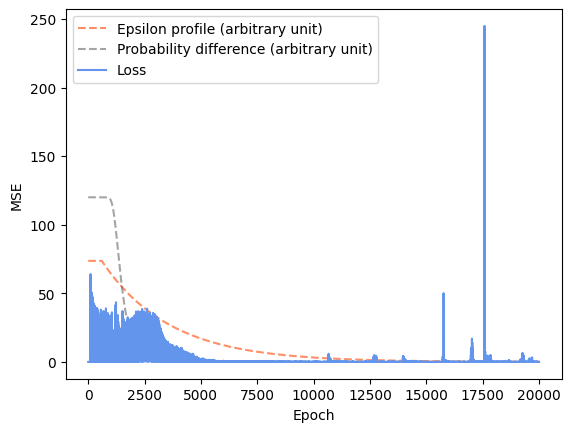

In [60]:
plt.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
plt.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
plt.plot(loss_log, label = 'Loss', color = 'cornflowerblue')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.savefig('loss.pdf', dpi = 300, bbox_inches='tight')
plt.show()

**Show the maze solution and the policy learnt.**

In [66]:
net.load_state_dict(torch.load("best.torch", weights_only=True))

<All keys matched successfully>

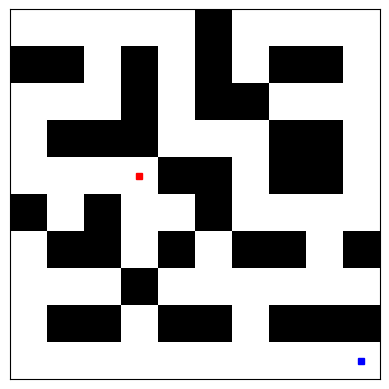

In [67]:
net.eval()
agent_start.isgameon = True
agent_start.use_softmax = False
_ = agent_start.env.reset(0)
while agent_start.isgameon:
    agent_start.make_a_move(net, 0.8)
    agent_start.env.draw('')
    clear_output(wait = True)

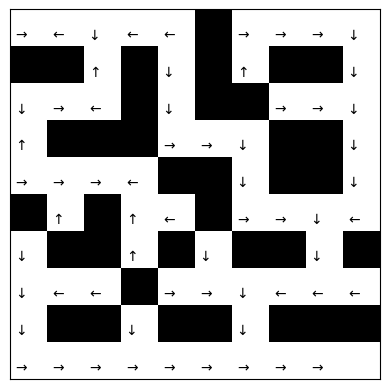

In [68]:
agent_start.plot_policy_map(net, './results/solution.pdf', [0.35,-0.3])

In [69]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load('best.torch'))

/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_2318/1177695741.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_net.load_state_dict(torch.load('best.torc

<All keys matched successfully>

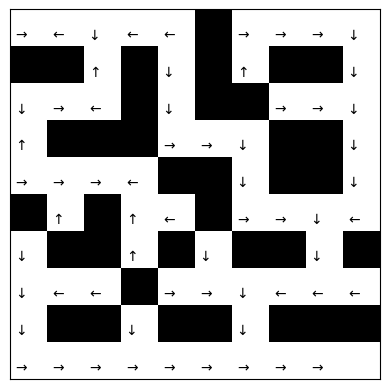

In [70]:
agent_start.plot_policy_map(best_net, './results/classical_solution_best.pdf', [0.35,-0.3])